In [1]:
import os
import sys
import glob

import numpy as np
import scipy as sp
import pandas as pd

from learning_dist_metrics.ldm import LDM
from learning_dist_metrics.datasets import load_data

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = load_data.load_sample_data()
print df.data.shape
print len(df.sim_pairs)

(100, 3)
2450


In [3]:
ldm = LDM()
ldm.fit(df.data, df.sim_pairs)

--- 6.19167089462 seconds ---


### Experiment 01
There are two group of users distinguished by their logic when determining friendships.

* dist_01(a, b) = 0.5 x_0 + 0.3 x_1 + 0.2 x_2
* dist_02(a, b) = 0.5 x_3 + 0.3 x_4 + 0.2 x_5
* P(Friend | dist < threshold) = 0.8
* P(Friend | dist >= threshold) = 0.2

** Example: **
user profile: {"ID": 1, "decision_type": , "x0":, "x1":, "x2":, "x3":, "x4":, "x5":}

In [58]:
from scipy.spatial.distance import euclidean
from numpy.random import uniform
from numpy.random import binomial

## ######################### ##
## GENERATE EXMPERIMENT DATA ##
## ######################### ##
np.random.seed(20150408)
n_samples = 100
 
users = pd.DataFrame(
    {"ID": range(n_samples),
     "decision_style": np.random.choice([0, 1], size = n_samples, replace=True, p = (0.7, 0.3)),
     "x0": np.random.uniform(0, 1, n_samples),
     "x1": np.random.uniform(0, 1, n_samples),
     "x2": np.random.uniform(0, 1, n_samples),
     "x3": np.random.uniform(0, 1, n_samples),
     "x4": np.random.uniform(0, 1, n_samples),
     "x5": np.random.uniform(0, 1, n_samples)
     })

#### Social Model:
create simulated pairwise user friendships.

In [5]:
## ########################## ##
## DATA SIMULATION LOGIC      ##
## ########################## ##
def dist_func(a, b, weights = None):
    """Calculate the distance
    """
    if weights == None:
        weights = [1] * len(a)
        
    a = np.array(a) * weights
    b = np.array(b) * weights
    return euclidean(a, b)
 
def is_friends(dist, threshold = 0.3):
    """Return 1 if user decided to become a friend
       Or 0, if the user does not want to become a friend
       with other. The underlying logic governing the
       decision-makeing follows a mixture of two binomial
       distributions which is parametrized by distance
       between two users.

       Decision logic:
       ===============
       if distance < threshold, \beta = 0.7
       else, \beta = 0.2
    """
    if dist <= threshold:
        res = binomial(1, 0.9)
    else:
        res = binomial(1, 0.1)
    return res
 
def decision_rule_01(a, b):
    weights = [0.5, 0.5, 0.1, 0., 0., 0.]
    return dist_func(a, b, weights)
 
def decision_rule_02(a, b):
    weights = [0., 0., 0., 0.5, 0.3, 0.2]
    return dist_func(a, b, weights)
 
def decision_rule(a, b, type_idx):
    """ Consolidate decision_rule_01 and decision_rule_02
        into a single function to unify the interface
    """
    if type_idx == 0:
        res = decision_rule_01(a, b)
    elif type_idx == 1:
        res = decision_rule_02(a, b)
    else:
        res = dist_func(a, b)
    return res
 
def make_connection(decision_a, decision_b):
    """Return 1 if decision_a and decision_b are both 1(s)
       to indicate two parties aggree to be connected
       Otherwise, return 0
    """
    if decision_a == 1 and decision_b == 1:
        res = 1
    else:
        res = 0
    return res
 
def friendship_agreement(a_id, b_id, \
                         a_profile, b_profile, \
                         a_dec_rule, b_dec_rule):
    """ Mathematical simulation
    """
    dist_a = decision_rule(a_profile, b_profile, a_dec_rule)
    dist_b = decision_rule(b_profile, a_profile, b_dec_rule)
    dec_a = is_friends(dist_a)
    dec_b = is_friends(dist_b)
    is_connected = make_connection(dec_a, dec_b)
    if a_id > b_id:
        res = [b_id, a_id, is_connected]
    else:
        res = [a_id, b_id, is_connected]
    return res

**dist_df** is the matrix of pairwise distance matrix with user_a's viewpoint

    **Example:** (user_id_a, user_id_b, dist(a, b, view_a), dist(a, b, view_b))

**rel_df** is the social relationship of users

    **Example:** (user_id_a, user_id_b, 1 or 0)

In [191]:
all_users = set(users.loc[:, "ID"])
rel_df = np.empty([len(all_users) * len(all_users), 3])
dist_df = np.empty([len(all_users) * len(all_users), 4])

row_counter = 0
for a_id in all_users:
    for b_id in all_users:
        if a_id != b_id:
            a_pos = [i for i, val in enumerate(users["ID"] == a_id) if val]
            b_pos = [i for i, val in enumerate(users["ID"] == b_id) if val]
            
            a_dec_rule = users.loc[a_pos, "decision_style"].as_matrix()
            a_profile  = users.iloc[a_pos, 2:].as_matrix()
            b_dec_rule = users.loc[b_pos, "decision_style"].as_matrix()
            b_profile  = users.iloc[b_pos, 2:].as_matrix()
            
            dist_df[row_counter, :] = [a_id, b_id, \
                                       decision_rule(a_profile, b_profile, a_dec_rule), \
                                       decision_rule(b_profile, a_profile, b_dec_rule)]
            rel_df[row_counter, :] = \
                friendship_agreement(a_id, b_id, a_profile, b_profile, \
                                     a_dec_rule, b_dec_rule)
            row_counter += 1
        else:
            rel_df[row_counter, :] = [a_id, b_id, np.nan]
            row_counter += 1

## Convert np.array() to pd.DataFrame()
dist_df = pd.DataFrame(dist_df, columns = ["uid_a", "uid_b", "distance_a2b", "distance_b2a"])
rel_df = pd.DataFrame(rel_df, columns = ["uid_a", "uid_b", "isFriend"])
## Drop A-A pairs
dist_df = dist_df.dropna()
rel_df = rel_df.dropna()

#### Examine the distribution of distance from user a's view point (3D)

1. **Blue** is the histogram of pairwise distance from A's viewpoint
2. **Orange** is the hsitogram of pairwise distance from B's viewpint (Same)

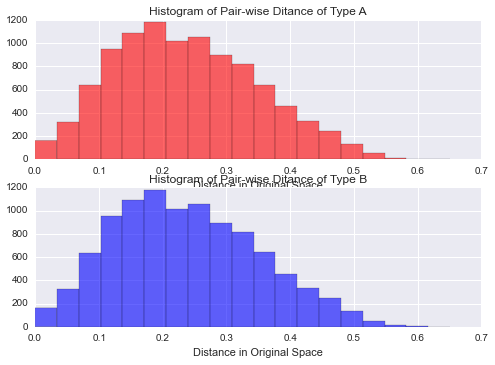

In [19]:
import seaborn as sns
sns.set(style="darkgrid")

max_data = max(dist_df.iloc[:, 2:].max())
min_data = min(dist_df.iloc[:, 2:].min())
bins = np.linspace(min_data, max_data, 20)

plt.figure(1)
plt.subplot(211)
plt.hist(dist_df['distance_a2b'], bins, normed=False, color="r", alpha=.6)
plt.xlabel("Distance in Original Space")
plt.title("Histogram of Pair-wise Ditance of Type A")

plt.subplot(212)
plt.hist(dist_df['distance_b2a'], bins, normed=False, color="b", alpha=.6)
plt.xlabel("Distance in Original Space")
plt.title("Histogram of Pair-wise Ditance of Type B")

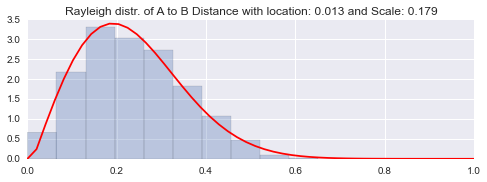

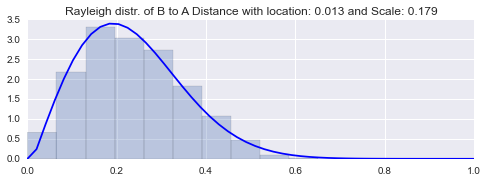

In [188]:
from scipy.stats import rayleigh
from pylab import plot,show,hist,figure,title

## ####################### ##
## Distance a to b         ##
## ####################### ##
## Fit the distribution
param_dist_a2b = rayleigh.fit(dist_df['distance_a2b'])
x4plot = np.linspace(0, 1)
pdf_fitted = rayleigh.pdf(x4plot, loc=param_dist_a2b[0],scale=param_dist_a2b[1])

plt.figure(1)
plt.subplot(211)
## Visualize the distribution
title_str = "Rayleigh distr. of A to B Distance with location: %.3f and Scale: %.3f" % param_dist_a2b
title(title_str)
plot(x4plot, pdf_fitted,'r-')
hist(dist_df['distance_a2b'],normed=1,alpha=.3)
show()

## ####################### ##
## Distance a to b         ##
## ####################### ##
param_dist_b2a = rayleigh.fit(dist_df['distance_b2a'])
pdf_fitted = rayleigh.pdf(x4plot, loc=param_dist_b2a[0],scale=param_dist_b2a[1])

plt.subplot(212)
## Visualize the distribution
title_str = "Rayleigh distr. of B to A Distance with location: %.3f and Scale: %.3f" % param_dist_b2a
title(title_str)
plot(x4plot, pdf_fitted,'b-')
hist(dist_df['distance_b2a'], normed=1, alpha=.3)
show()

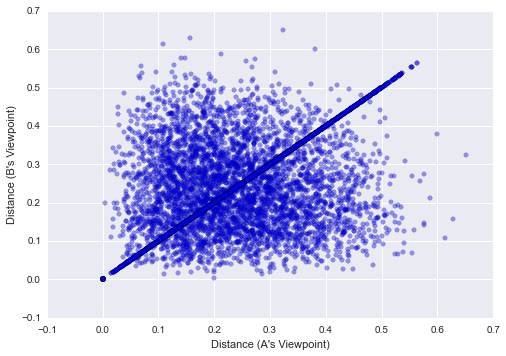

In [189]:
plt.scatter(dist_df['distance_a2b'], dist_df['distance_b2a'], alpha = 0.4)
plt.xlabel("Distance (A's Viewpoint)")
plt.ylabel("Distance (B's Viewpoint)")

The # of friendship is dependent on the threshold and distribution of pairwise distance

In [13]:
print "# of friendships: %d" % sum(rel_df.isFriend)
print "# of user pairs: %d" % rel_df.shape[0]

# of friendships: 5105
# of user pairs: 9900


### Create a list of user id pairs to represent connceted friendships

In [14]:
friendships = []
for idx, info in rel_df.iterrows():
    if info[2] == 1:
        friendships.append((info[0], info[1]))

### Fit the 1st LDM() model
At initial iteration, learning the distance metrics is conducted by loading the entire data sets.

In [15]:
r01_ldm = LDM()
r01_ldm.fit(users.iloc[:, 2:].as_matrix(), friendships)

--- 197.388208151 seconds ---


In [16]:
r01_ldm.get_transform_matrix()

[0.33, 0.67, 0.0, 0.0, 0.0, 0.0]

### Fit the 2nd LDM() model
Fit type 01 friendships only.

In [168]:
all_users_type_a = users.ix[users.decision_style == 0, "ID"]
friendships_type_a = [(a, b) for a, b in friendships \
                      if (a in all_users_type_a) or (b in all_users_type_a)
                     ]
## fitting models
r02_ldm = LDM()
r02_ldm.fit(users.iloc[:, 2:].as_matrix(), friendships_type_a)
r02_ldm.get_transform_matrix()

--- 74.5672168732 seconds ---


[0.51, 0.49, 0.0, 0.0, 0.0, 0.0]

### Fit the 3rd LDM() model
Fit type 02 friendships only.

In [190]:
all_users_type_b = users.ix[users.decision_style == 1, "ID"]
friendships_type_b = [(a, b) for a, b in friendships \
                      if (a in all_users_type_b) or (b in all_users_type_b)
                     ]
## fitting models
r03_ldm = LDM()
r03_ldm.fit(users.iloc[:, 2:].as_matrix(), friendships_type_b)
r03_ldm.get_transform_matrix()

--- 63.5558428764 seconds ---


[0.03, 0.16, 0.0, 0.82, 0.0, 0.0]

### Examine the distribution of distance within the transformed space


In [136]:
tfm_users.iloc[0, :]

x0     0.069476
x1     0.047968
x2     0.000000
x3     0.000000
x4     0.000000
x5     0.000000
uid    0.000000
Name: 0, dtype: float64

In [143]:
from scipy.spatial.distance import euclidean

def pair_wise_dist(pairs, profile_db = None):
    """Calculate euclidean distance between two users 
    """
    a, b = pairs
    if isinstance(profile_db, np.ndarray):
        a_vec, b_vec = profile_db[a, :], profile_db[b, :]
    elif isinstance(profile_db, pd.DataFrame):
        a_vec = profile_db.ix[profile_db.ID == a, 2:].as_matrix()
        b_vec = profile_db.ix[profile_db.ID == b, 2:].as_matrix()
    else:
        pass
    return euclidean(a_vec, b_vec)

def get_unc_id(user_id, connected_list, all_user_list):
    """Get unconnected user_id based by excluding
       users being connnected (rel_df) from 
       all candidate users
       
       Parameters:
       ===========
       user_id:
       connected_list:
       all_user_list:
       
       Return:
       =======
       list: pairs of user ids
    """
    connected_uids = connected_list.loc[(connected_list.uid_a == user_id) & \
                                        (connected_list.isFriend == 1), \
                                        "uid_b"]
    
    unconnected_uids = [(user_id, i) for i in all_user_list \
                        if i not in connected_uids]
    
    return unconnected_uids

def get_all_dist(pair_list, profile_db):
    """
    """
    dist = [ pair_wise_dist(p, profile_db) for p in pair_list ]
    return dist

def get_all_unc_dist(user_id, dist_db, \
                     profile_db, all_user_list):
    """
    """
    unc_pair_list = get_unc_id(user_id, dist_db, all_user_list)
    res = get_all_dist(unc_pair_list, profile_db)
    return res

##### Visualize the distribution of distance between users under friendships vs. non-friendships

In [170]:
tfm_users = r01_ldm.transform(users.iloc[:, 2:])

tfm_users["ID"] = users.ID
tfm_users["decision_style"] = users.decision_style

## Calculate transformed 
all_users = set(tfm_users.loc[:, "ID"])
#rel_df = np.empty([len(all_users) * len(all_users), 3])
tfm_dist_df = np.empty([len(all_users) * len(all_users), 4])

row_counter = 0
for a_id in all_users:
    for b_id in all_users:
        if a_id != b_id:
            a_pos = [i for i, val in enumerate(tfm_users["ID"] == a_id) if val]
            b_pos = [i for i, val in enumerate(tfm_users["ID"] == b_id) if val]
            
            a_dec_rule = tfm_users.loc[a_pos, "decision_style"].as_matrix()
            a_profile  = tfm_users.iloc[a_pos, 2:].as_matrix()
            b_dec_rule = tfm_users.loc[b_pos, "decision_style"].as_matrix()
            b_profile  = tfm_users.iloc[b_pos, 2:].as_matrix()
            
            tfm_dist_df[row_counter, :] = [a_id, b_id, \
                                       decision_rule(a_profile, b_profile, a_dec_rule), \
                                       decision_rule(b_profile, a_profile, b_dec_rule)]
            row_counter += 1
        else:
            row_counter += 1

## Convert np.array() to pd.DataFrame()
tfm_dist_df = pd.DataFrame(tfm_dist_df, columns = ["uid_a", "uid_b", "distance_a2b", "distance_b2a"])
## Drop A-A pairs
tfm_dist_df = dist_df.dropna()

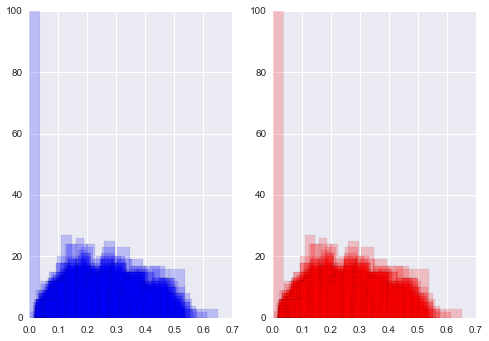

In [171]:
all_users = set(users['ID'])
all_users = [i for i in all_users]

plt.figure(1)
## ####################### ##
## PLOT FOR ORIGINAL SPACE ##
## ####################### ##
plt.subplot(121)

for uid in all_users:
    ## Unconnected
    ##pd.Series(get_all_unc_dist(uid, dist_df, tfm_db_mtx, all_users))\
    ##.hist(color = 'y', alpha = .05, bins = 10)
    ## Connected
    dist_df.loc[dist_df.uid_a == uid, "distance_a2b"].hist(color = 'b', alpha = .10, bins = 10)
    dist_df.loc[dist_df.uid_b == uid, "distance_b2a"].hist(color = 'b', alpha = .10, bins = 10)
    
## ########################## ##
## PLOT FOR TRANSFORMED SPACE ##
## ########################## ##
plt.subplot(122)

for uid in all_users:
    ## Unconnected
    ##pd.Series(get_all_unc_dist(uid, dist_df, tfm_db_mtx, all_users))\
    ##.hist(color = 'y', alpha = .05, bins = 10)
    ## Connected
    tfm_dist_df.loc[tfm_dist_df.uid_a == uid, "distance_a2b"].hist(color = 'r', alpha = .10, bins = 10)
    tfm_dist_df.loc[tfm_dist_df.uid_b == uid, "distance_b2a"].hist(color = 'r', alpha = .10, bins = 10)